In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline
np.random.seed(666)

Using TensorFlow backend.


In [3]:
#Load data
train = pd.read_json("input/train.json")
test = pd.read_json("input/test.json")

# replace NAs with 0 in inc_angle column.
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

In [4]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

In [5]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()


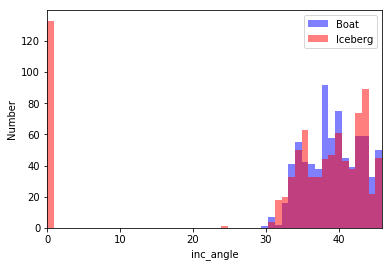

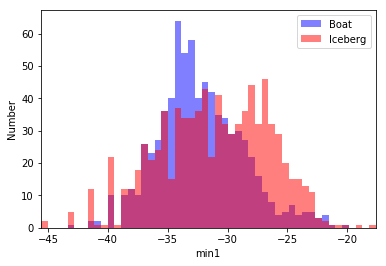

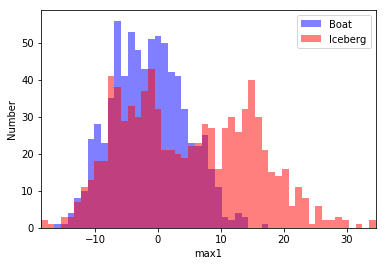

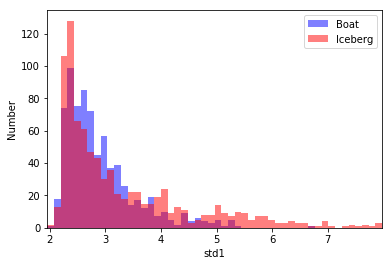

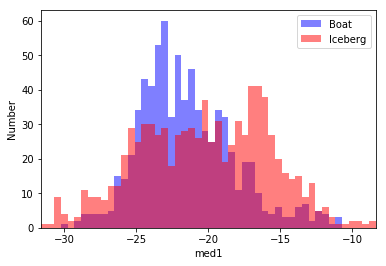

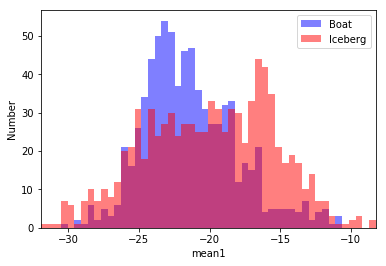

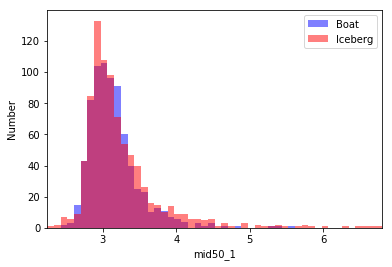

In [6]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

---


In [7]:
# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis], x_band2[:, :, :, np.newaxis]], axis=-1)
y_train = np.array(train["is_iceberg"])
print("Xtrain:", X_train.shape)
print("Ytrain:", y_train.shape)
# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis], x_band2[:, :, :, np.newaxis]], axis=-1)
print("Xtest:", X_test.shape)

Xtrain: (1604, 75, 75, 2)
Ytrain: (1604,)
Xtest: (8424, 75, 75, 2)


In [8]:
from keras.models import Sequential
from keras.layers import Convolution2D, GlobalAveragePooling2D, Dense, Dropout

In [9]:
model = Sequential()
model.add(Convolution2D(32, 3, activation="relu", input_shape=(75, 75, 2)))
model.add(Convolution2D(64, 3, activation="relu", input_shape=(75, 75, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,169
Trainable params: 19,169
Non-trainable params: 0
_________________________________________________________________


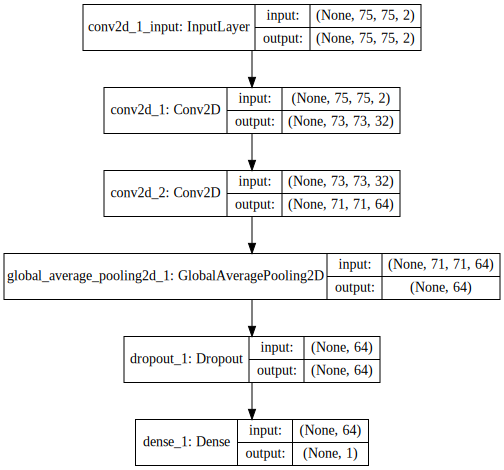

In [10]:
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

In [11]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True)

In [12]:
xz = model.fit(X_train, y_train, epochs=10, validation_split=0.25)

Train on 1203 samples, validate on 401 samples
Epoch 1/10
1203/1203 [==============================] - 2s 2ms/step - loss: 0.9586 - acc: 0.5777 - val_loss: 0.6383 - val_acc: 0.5985
Epoch 2/10
1203/1203 [==============================] - 1s 1ms/step - loss: 0.6266 - acc: 0.6276 - val_loss: 0.6199 - val_acc: 0.5786
Epoch 3/10
1203/1203 [==============================] - 1s 1ms/step - loss: 0.5995 - acc: 0.6642 - val_loss: 0.6279 - val_acc: 0.5536
Epoch 4/10
1203/1203 [==============================] - 1s 1ms/step - loss: 0.5700 - acc: 0.6883 - val_loss: 0.6276 - val_acc: 0.5511
Epoch 5/10
1203/1203 [==============================] - 1s 1ms/step - loss: 0.5640 - acc: 0.6933 - val_loss: 0.6125 - val_acc: 0.5636
Epoch 6/10
1203/1203 [==============================] - 1s 1ms/step - loss: 0.5621 - acc: 0.6916 - val_loss: 0.6060 - val_acc: 0.5611
Epoch 7/10
1203/1203 [==============================] - 1s 1ms/step - loss: 0.5568 - acc: 0.7041 - val_loss: 0.6111 - val_acc: 0.5636
Epoch 8/10
1203

In [13]:
xz.history

{'acc': [0.57772236106203478,
  0.62759767233681307,
  0.66417290127881845,
  0.68827930125016923,
  0.69326683346271911,
  0.69160432282429585,
  0.70407315075447041,
  0.70324189536093873,
  0.70822942722666193,
  0.71238570258405343],
 'loss': [0.95857326407682275,
  0.62663332859080534,
  0.59945414181262968,
  0.56996848275041145,
  0.5640038461954715,
  0.56206448402190745,
  0.5567633269830039,
  0.54938285497457706,
  0.54551006354397769,
  0.54521799374895108],
 'val_acc': [0.59850374168885911,
  0.57855361700057983,
  0.55361596047135064,
  0.55112219488531577,
  0.56359102281549034,
  0.56109725737809535,
  0.56359102296413033,
  0.57855361648033976,
  0.5660847885501652,
  0.5760598507456649],
 'val_loss': [0.6382845467760081,
  0.61992688369275328,
  0.62793819610020174,
  0.627625585494196,
  0.61252939463256306,
  0.60598422449425871,
  0.61113002888876899,
  0.60954373554695873,
  0.61223516945827039,
  0.59617643314704039]}

---

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, GlobalMaxPooling2D, Dense
improved_cnn = Sequential()
improved_cnn.add(BatchNormalization(input_shape = (75, 75, 2)))
for i in range(4):
    improved_cnn.add(Conv2D(8*2**i, kernel_size = (3,3)))
    improved_cnn.add(MaxPooling2D((2,2)))
improved_cnn.add(GlobalMaxPooling2D())
improved_cnn.add(Dropout(0.2))
improved_cnn.add(Dense(64))
improved_cnn.add(Dropout(0.2))
improved_cnn.add(Dense(32))
improved_cnn.add(Dense(1, activation = 'sigmoid'))
improved_cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
improved_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 75, 75, 2)         8         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 73, 73, 8)         152       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
__________

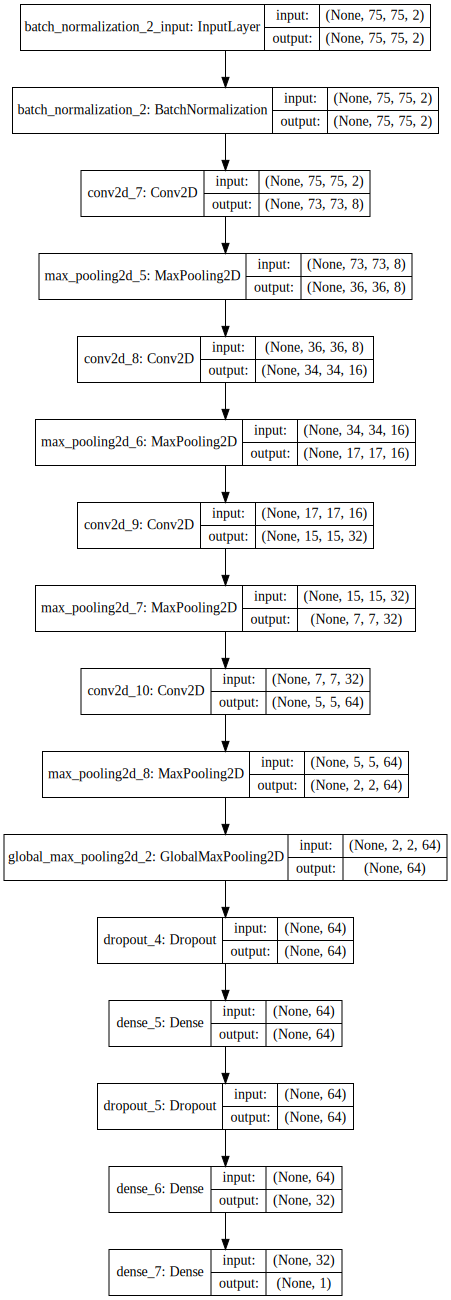

In [27]:
SVG(model_to_dot(improved_cnn, show_shapes = True).create(prog='dot', format='svg'))

In [28]:
history1 = improved_cnn.fit(X_train, y_train, validation_split=0.2, epochs = 30)

Train on 1283 samples, validate on 321 samples
Epoch 1/30
1283/1283 [==============================] - 2s 1ms/step - loss: 0.6454 - acc: 0.6033 - val_loss: 0.5568 - val_acc: 0.6822
Epoch 2/30
1283/1283 [==============================] - 1s 476us/step - loss: 0.5460 - acc: 0.7023 - val_loss: 0.4957 - val_acc: 0.6822
Epoch 3/30
1283/1283 [==============================] - 1s 475us/step - loss: 0.4333 - acc: 0.7825 - val_loss: 0.3754 - val_acc: 0.8162
Epoch 4/30
1283/1283 [==============================] - 1s 472us/step - loss: 0.3704 - acc: 0.8309 - val_loss: 0.4253 - val_acc: 0.7539
Epoch 5/30
1283/1283 [==============================] - 1s 473us/step - loss: 0.3261 - acc: 0.8542 - val_loss: 0.3295 - val_acc: 0.8131
Epoch 6/30
1283/1283 [==============================] - 1s 473us/step - loss: 0.3197 - acc: 0.8613 - val_loss: 0.3306 - val_acc: 0.8349
Epoch 7/30
1283/1283 [==============================] - 1s 470us/step - loss: 0.2424 - acc: 0.9002 - val_loss: 0.2968 - val_acc: 0.8505
Epo

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


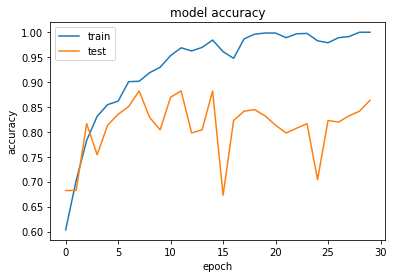

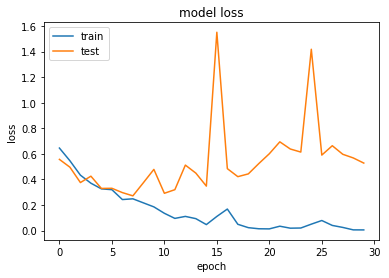

In [29]:
# list all data in history
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# Make predictions
prediction = improved_cnn.predict(X_test, verbose=1)

8424/8424 [==============================] - 1s 141us/step


In [31]:
prediction

array([[  8.45739196e-05],
       [  9.97828543e-01],
       [  9.82402382e-10],
       ..., 
       [  1.23396376e-03],
       [  9.99999881e-01],
       [  2.27747127e-01]], dtype=float32)